In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from PIL import Image
from pathlib import Path
plt.rcParams["figure.figsize"] = (25,5)

In [5]:
import torch 
t = torch.load('temp_tensor.pth',map_location='cpu')

In [17]:
def clip_data(a):
    '''
    a: torch.tensor
    Clipping input data to the valid range for imshow with RGB data ([0..1] for floats
    '''
    a_min = a.min()
    a_max = a.max()
    return torch.clip((a-a_min)/torch.abs(a_max-a_min),0,1)

In [18]:
t = clip_data(t)

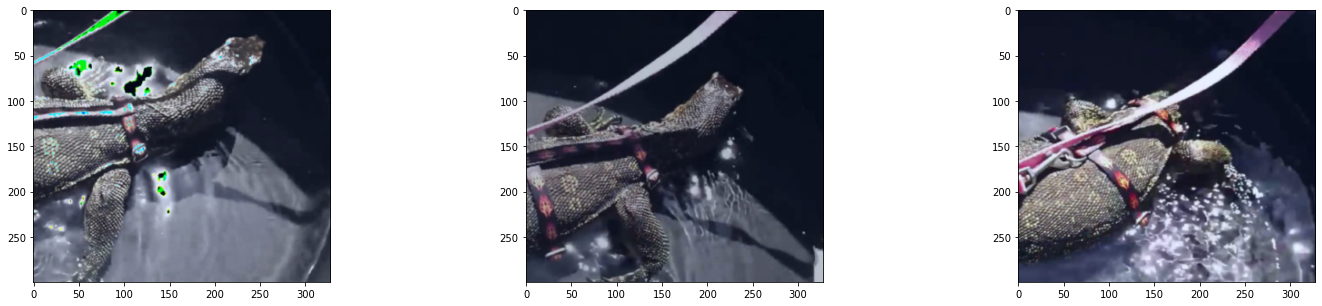

In [20]:
fig, axes = plt.subplots(1,3)
# b = 1
for i in range(len(axes)):
    im = t[i+3].numpy().transpose((1,2,0))
    axes[i].imshow(im)
    # axes[i].axis('off')

In [2]:
from datasets.ytvis import make_coco_transforms, YTVISDataset

In [3]:
def plotTarget(target):
    """
    Display the specified annotations.
    :param target (dict)
    :return: None
    """
    
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    class_color = ['blue', 'orange', 'green', 'red', 'purple', 'brown','pink','olive']
    # assert len(class_color) == len(self.cats)
    color = []

    for i in range(len(target['boxes'])):
        c = class_color[target['labels'][i]]
        [bbox_x, bbox_y, bbox_x2, bbox_y2] = target['boxes'][i]
        poly = [[bbox_x, bbox_y], [bbox_x, bbox_y2], [bbox_x2, bbox_y2], [bbox_x2, bbox_y]]
        np_poly = np.array(poly).reshape((4,2))
        polygons.append(Polygon(np_poly))
        color.append(c)
    
    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

In [4]:
import datasets.transforms as T
def make_transforms(image_set):

    normalize = T.Compose([
        T.ToTensor(),
        # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #mean variance
    ]) # TODO:

    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768]

    if image_set == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomResize(scales, max_size=800),
            # T.PhotometricDistort(),
            T.Compose([
                     T.RandomResize([400, 500, 600]),
                     T.RandomSizeCrop(384, 600),
                     # To suit the GPU memory the scale might be different
                     T.RandomResize([300], max_size=540),#for r50
                     #T.RandomResize([280], max_size=504),#for r101
            ]),
            normalize,
        ])
        # return T.Compose([T.RandomResize([500], max_size=540), T.ToTensor()])

    if image_set == 'val':
        return T.Compose([
            T.RandomResize([360], max_size=640),
            normalize,
        ])
        # return T.Compose([T.RandomResize([500], max_size=540), T.ToTensor()])

    raise ValueError(f'unknown {image_set}')

In [5]:
image_set = 'train'
root = Path('/nobackup/yb/ytvos_data')
PATHS = {
            "train": (root / "train" / "JPEGImages", root / "annotations" / "train_argoformat.json"),
            "val": (root / "train" / "JPEGImages", root / "annotations" / "val_argoformat.json")
    }

data_dir, json_file = PATHS[image_set]
dataset = YTVISDataset(data_dir, json_file, transforms=T.ToTensor())
print('len',dataset.__len__())

loading annotations into memory...
Done (t=12.50s)
creating index...
index created!
len 10881


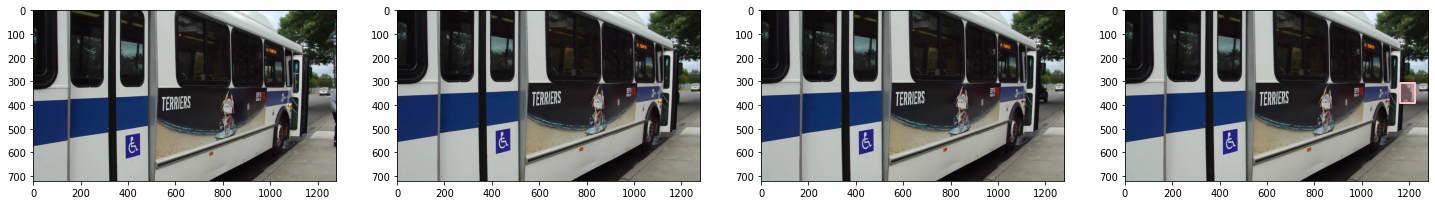

In [6]:
# * test dataloader
#  visualize from dataset class with data aug (actual input to)
video, target = dataset.__getitem__(0)

fig, axes = plt.subplots(1,dataset.num_frames+1)
for i in range(len(axes[:-1])):
    im = video[i*3:(i+1)*3].numpy().transpose((1,2,0))
    axes[i].imshow(im)
    # axes[i].axis('off')

axes[-1].imshow(im)#, axes[-1].axis('off')
plotTarget(target)

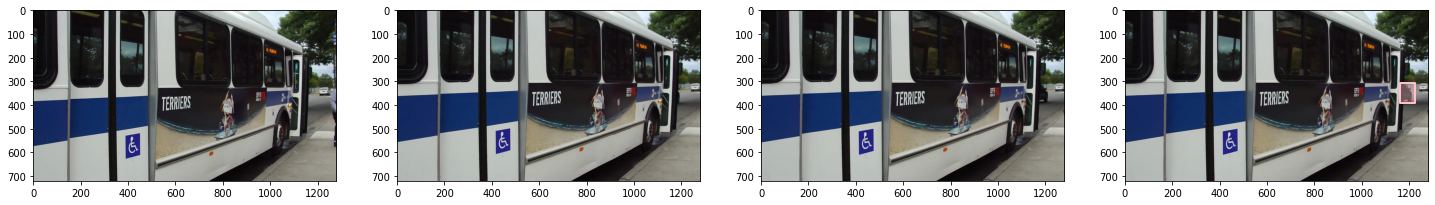

In [7]:
# * test the api
index = 0
imgs = dataset.load_images(index)

fig, axes = plt.subplots(1,dataset.num_frames+1)
for i in range(len(axes[:-1])):
    axes[i].imshow(imgs[i])
    # axes[i].axis('off')

axes[-1].imshow(imgs[-1])#, axes[-1].axis('off')
anns = dataset.load_anns(index)
dataset.api.showAnns(anns)

In [8]:
# * dataset analysis